In [1]:
import os
import pathlib
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display

import tensorflow as tf
from tensorflow import keras


from sklearn.model_selection import train_test_split

seed = 666
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print(tf.__version__)
gpus = tf.config.list_physical_devices(device_type='GPU')
cpus = tf.config.list_physical_devices(device_type='CPU')
print(gpus)
print(cpus)

2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Prepare dataset

In [3]:
data_path = 'data/mini_speech_commands'

data_dir = pathlib.Path(data_path)
if not data_dir.exists():
    tf.keras.utils.get_file(
      fname='mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
else:
    print('Dataset already exist!')

Dataset already exist!


In [4]:
path = Path(data_path)
commands = [command.stem for command in path.iterdir()]   # ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

In [5]:
filenames = []
for each_command in path.iterdir():
    cnt = 0
    for each_file in each_command.iterdir():
        filenames.append(tf.convert_to_tensor(str(each_file)))
        cnt += 1
    print(f'{each_command.stem}: {cnt}')
print('-'*20)
print(f'Total: {len(filenames)} examples')
print(filenames[0])
filenames = tf.random.shuffle(filenames)
print(filenames[0])

down: 1000
go: 1000
left: 1000
no: 1000
right: 1000
stop: 1000
up: 1000
yes: 1000
--------------------
Total: 8000 examples
tf.Tensor(b'data\\mini_speech_commands\\down\\004ae714_nohash_0.wav', shape=(), dtype=string)
tf.Tensor(b'data\\mini_speech_commands\\yes\\3b8406c0_nohash_0.wav', shape=(), dtype=string)


In [6]:
# split into train, test, val
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size   ', len(train_files))
print('Validation set size ', len(val_files))
print('Test set size       ', len(test_files))

Training set size    6400
Validation set size  800
Test set size        800


## Preprocesses the raw WAV audio files

In [7]:
def decode_audio(audio_binary):
    audio, sample_rate = tf.audio.decode_wav(contents=audio_binary)   # audio: [samples, channels], where channels is 1 for mono or 2 for stereo
    return tf.squeeze(audio, axis=-1)    # Since all the data is single channel (mono), drop the 'channels' axis from the array

In [8]:
def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label   # prepare for supervised learning

In [10]:
AUTOTUNE = tf.data.AUTOTUNE   # prompt the tf.data runtime to tune the value dynamically at runtime

files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)   # (tf.float32, tf.string)
# This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input
# The value or values returned by map_func determine the structure of each element in the returned dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [11]:
# Test files_ds
for f in files_ds.take(1):
    print(f.numpy().decode('utf-8'))

data\mini_speech_commands\yes\3b8406c0_nohash_0.wav


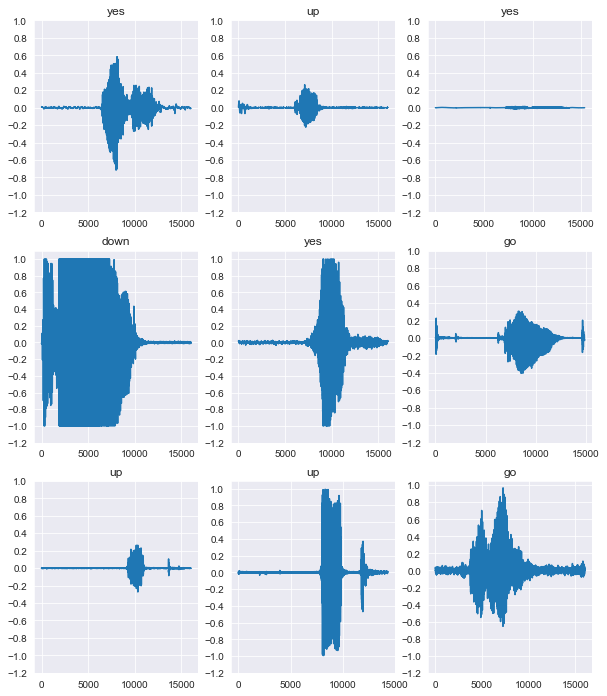

In [12]:
# Test waveform_ds
rows = 3
cols = 3
n = rows * cols
fig, axs = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    row = i // rows
    col = i % cols
    ax = axs[row][col]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    ax.set_title(label.numpy().decode('utf-8'))
plt.show()

100%|██████████| 8000/8000 [02:06<00:00, 63.09it/s] 


<Figure size 720x576 with 0 Axes>

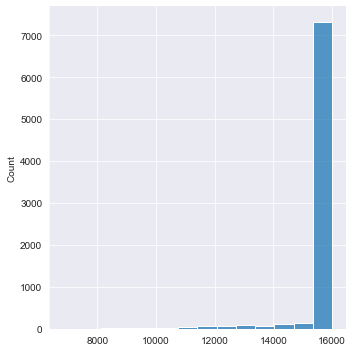

In [13]:
# show number of waveform samples of all 8000 audios
waveform_samples_lst = []
for file_path in tqdm(filenames):
    waveform_samples, label = get_waveform_and_label(file_path)
    # print(tf.shape(waveform_samples))
    waveform_samples_lst.append(tf.shape(waveform_samples).numpy().item())
plt.figure(figsize=(10, 8))
sns.displot(waveform_samples_lst)
plt.show()

In [14]:
print(np.max(waveform_samples_lst))
print(np.min(waveform_samples_lst))

16000
6827


## Convert waveforms to spectrograms

In [15]:
def get_spectrogram(waveform):
    input_len = 16000
    if tf.shape(waveform) > input_len:
        waveform = waveform[: input_len]   # in this dataset, the max samples of waveform is 16000
    elif tf.shape(waveform) < input_len:
        zero_padding = tf.zeros(shape=[16000]-tf.shape(waveform), dtype=tf.float32)
        waveform = tf.cast(waveform, dtype=tf.float32)   # make sure waveform has the same type as zero padding
        waveform = tf.concat([waveform, zero_padding], axis=0)   # waveform with zero padding
    spectrogram = tf.signal.stft(signals=waveform, frame_length=255, frame_step=128)   # convert the waveform to a spectrogram via a STFT
    ## frame_length	An integer scalar Tensor. The window length in samples.
    ## frame_step	An integer scalar Tensor. The number of samples to step.
    spectrogram = tf.abs(spectrogram)   # magnitude + phase. use tf.abs to get rid of phase
    spectrogram = spectrogram[..., tf.newaxis]     # Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution layers (which expect shape (`batch_size`, `height`, `width`, `channels`)
    return spectrogram   # 'tensorflow.python.framework.ops.EagerTensor' object

In [16]:
# Test get_spectrogram()
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spec = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spec.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [17]:
# len(spec.numpy().shape)   # 3
# np.size(spec.numpy())   # 15996

## Display a spectrogram

In [18]:
def plot_spectrogram(spectrogram, ax, debug=False):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        new_spectrogram = np.squeeze(spectrogram, axis=-1)   # (124, 129, 1) -> (124, 129)
    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns).
    log_spec = np.log(new_spectrogram.T + np.finfo(float).eps)     # add an epsilon to avoid taking a log of zero, (129, 124)
    if debug:
        print('old spectrogram shape: ', spectrogram.shape)
        print('new spectrogram shape: ', new_spectrogram.shape)
        print('log spec shape: ', log_spec.shape)
        print('spectrogram size: ', np.size(new_spectrogram))
    height = log_spec.shape[0]   # 129
    width = log_spec.shape[1]   # 124
    X = np.linspace(0, np.size(new_spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

old spectrogram shape:  (124, 129, 1)
new spectrogram shape:  (124, 129)
log spec shape:  (129, 124)
spectrogram size:  15996


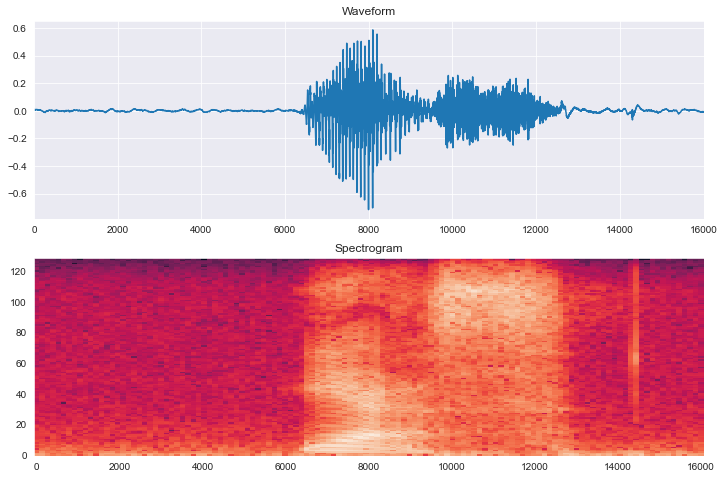

In [19]:
# Test plot_spectrogram()
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spec.numpy(), axes[1], debug=True)
axes[1].set_title('Spectrogram')
plt.show()

In [20]:
def get_spectrogram_and_label_id(waveform, label, debug=False):
    spectrogram = get_spectrogram(waveform)   # (124, 129, 1)
    label_id = tf.math.argmax(label == commands)   # int32
    if debug:
        print('spectrogram shape: ', spectrogram.shape)
        print('label id: ', label_id.numpy())
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)   # transforms the waveform dataset into spectrogram and their corresponding labels as integer IDs

In [21]:
# Test get_spectrogram_and_label_id()
w, la = get_waveform_and_label(filenames[10])
s, li = get_spectrogram_and_label_id(w, la, debug=True)

spectrogram shape:  (124, 129, 1)
label id:  4


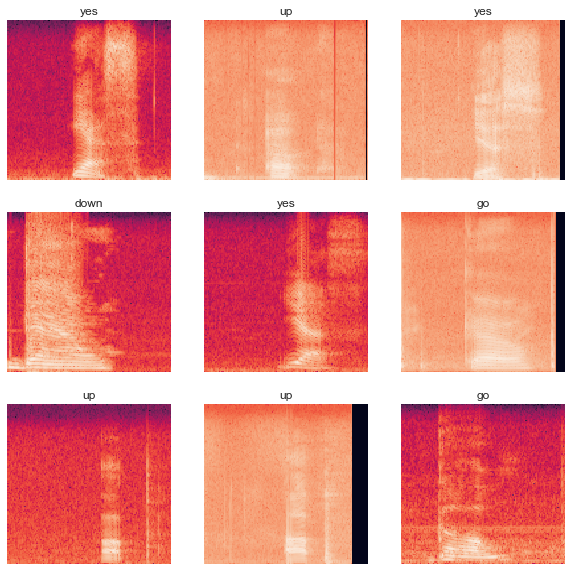

In [22]:
# Test spectrogram_ds
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

## Build and train the model

In [23]:
def preprocess_dataset(files):
    output_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = output_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds   # spectrogram_ds

In [24]:
train_ds = preprocess_dataset(train_files)
test_ds = preprocess_dataset(test_files)
val_ds = preprocess_dataset(val_files)

In [25]:
for s, l in train_ds.take(1):
    print(s.shape)
    print(l)

(124, 129, 1)
tf.Tensor(7, shape=(), dtype=int64)


In [26]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
# reduce read latency while training the model
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [27]:
for spectrogram, label_id in spectrogram_ds.take(1):
    input_shape = spectrogram.shape   # (124, 129, 1)
print('Input shape:', input_shape)
print('label: ', label_id)
num_labels = len(commands)   # 8

Input shape: (124, 129, 1)
label:  tf.Tensor(7, shape=(), dtype=int64)


In [28]:
# model
norm_layer = keras.layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, lab: spec))
model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Resizing(32, 32),
    norm_layer,
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

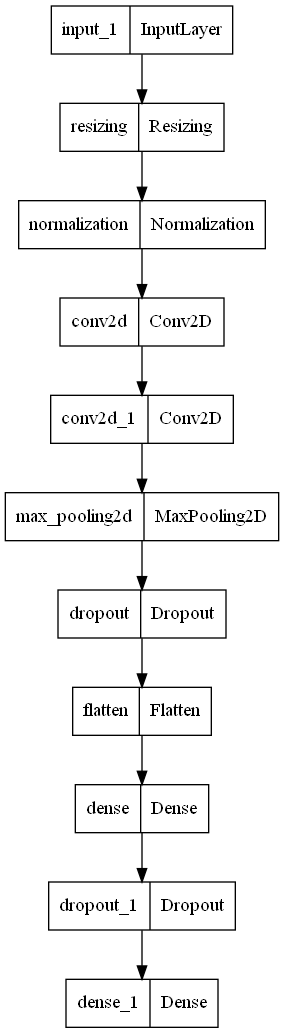

In [29]:
tf.keras.utils.plot_model(model)

In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
100/100 [==============================] - 24s 26ms/step - loss: 1.7210 - accuracy: 0.3778 - val_loss: 1.2480 - val_accuracy: 0.5700
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 1.1507 - accuracy: 0.5931 - val_loss: 0.9061 - val_accuracy: 0.7038
Epoch 3/50
100/100 [==============================] - 2s 19ms/step - loss: 0.8869 - accuracy: 0.6825 - val_loss: 0.7592 - val_accuracy: 0.7500
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.7173 - accuracy: 0.7428 - val_loss: 0.6671 - val_accuracy: 0.7763
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.7811 - val_loss: 0.6163 - val_accuracy: 0.7937
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.5412 - accuracy: 0.8092 - val_loss: 0.5473 - val_accuracy: 0.8188
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4973 - accuracy: 0.8245 - val_loss: 0.5400 - val_accuracy: 0.8238
Epo

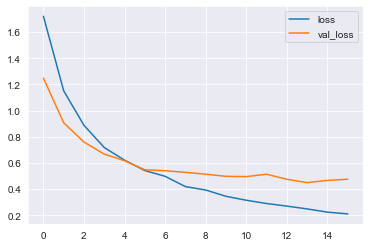

In [32]:
# visualization
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluation

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
print(test_labels)

[4 5 6 7 4 5 2 0 7 0 4 1 2 0 5 0 4 7 5 2 2 1 0 3 4 3 1 0 4 2 5 2 1 0 1 6 3
 6 7 3 3 7 7 2 7 4 3 4 4 3 4 6 6 1 1 7 2 0 2 3 0 2 7 5 3 2 5 0 4 1 1 6 5 6
 7 2 1 5 4 5 5 3 7 3 6 5 6 0 7 0 7 4 1 3 0 5 2 0 6 3 1 6 7 3 6 6 5 2 6 0 5
 6 6 1 5 4 1 1 1 2 3 1 4 2 2 1 6 5 1 6 0 4 7 4 6 5 0 0 4 3 4 2 0 0 1 0 2 1
 6 1 5 5 6 7 7 3 0 1 4 4 7 1 1 0 6 5 4 5 4 5 6 1 2 4 0 1 2 7 0 7 0 1 1 1 7
 0 3 4 4 0 5 2 5 2 5 7 1 7 1 4 5 1 5 0 6 7 3 4 6 6 3 6 6 2 6 1 1 7 7 2 5 7
 2 0 1 2 1 1 5 1 1 5 7 7 7 4 4 2 5 0 3 6 3 6 6 7 1 6 0 2 3 0 1 1 1 7 2 6 6
 5 2 5 3 5 7 6 6 3 0 2 5 1 4 4 2 3 5 5 1 7 7 6 1 5 3 1 3 6 1 2 3 2 7 5 1 2
 3 7 5 7 1 2 3 5 3 2 5 5 7 4 3 7 4 6 7 1 2 6 0 2 1 7 5 1 4 5 1 3 4 5 6 4 4
 2 4 1 0 3 1 7 2 1 7 3 6 3 6 6 0 6 7 3 5 7 3 5 0 2 7 6 4 3 5 7 1 7 2 1 2 4
 4 6 6 1 5 7 5 7 6 3 3 3 1 6 6 5 2 2 6 1 4 3 4 1 4 4 7 7 2 6 7 2 3 2 5 2 7
 1 5 3 1 5 7 1 7 1 1 1 0 5 3 2 1 6 4 3 3 7 1 5 2 1 2 4 2 5 2 3 3 1 2 6 7 2
 1 2 3 0 3 2 1 4 0 3 0 0 4 1 2 4 7 1 3 0 1 4 4 7 4 1 5 0 2 6 6 2 2 2 7 1 3
 7 7 7 4 2 6 4 7 4 3 4 5 

In [34]:
print(test_audio.shape)
print(test_labels.shape)

(800, 124, 129, 1)
(800,)


In [35]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

25/25 [==============================] - 0s 1ms/step


In [36]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 85%


## Display a confusion matrix

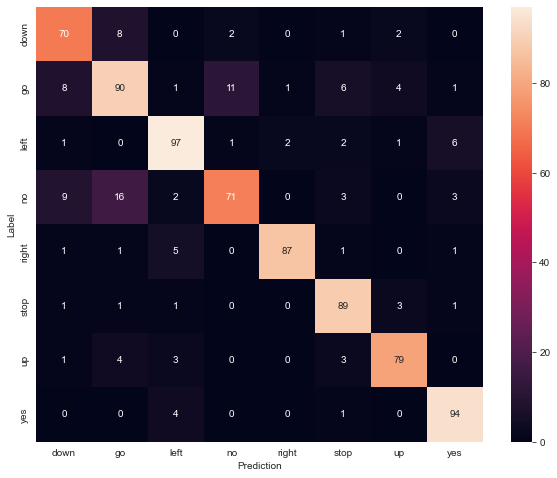

In [37]:
confusion_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save model

In [38]:
model_save_path = 'model'
tf.saved_model.save(obj=model, export_dir=model_save_path)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
